### Importing libraries

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import csv

### Ingesting Data

In [115]:
train = pd.read_csv('datasets/train.csv', index_col='Id', keep_default_na=False,
                                                       # na_values=
                                                        )
test =  pd.read_csv('datasets/test.csv', index_col='Id', keep_default_na=False,
                                                        #na_values=
                                                        )
#data = pd.concat([train, test])
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


### Changing Types

In [116]:
def clean_data(train):
    # Replace all instances of "NA" with "0" in column: 'LotFrontage'
    train['LotFrontage'] = train['LotFrontage'].str.replace("NA", "0", case=False, regex=False)
    # Change column type to float64 for column: 'LotFrontage'
    train = train.astype({'LotFrontage': 'float64'})
    # Change column type to category for column: 'MSSubClass'
    train = train.astype({'MSSubClass': 'category'})
    # Change column type to category for column: 'MSZoning'
    train = train.astype({'MSZoning': 'category'})
    # Change column type to category for column: 'Street'
    train = train.astype({'Street': 'category'})
    # Change column type to category for columns: 'Alley', 'LotShape' and 14 other columns
    train = train.astype({'Alley': 'category', 'LotShape': 'category', 'LandContour': 'category', 'Utilities': 'category', 'LotConfig': 'category', 'LandSlope': 'category', 'Neighborhood': 'category', 'Condition1': 'category', 'Condition2': 'category', 'BldgType': 'category', 'HouseStyle': 'category', 'RoofStyle': 'category', 'RoofMatl': 'category', 'Exterior1st': 'category', 'MasVnrType': 'category', 'Exterior2nd': 'category'})
    # Replace all instances of 0 with -0.1 in column: 'LotFrontage'
    train.loc[train['LotFrontage'] == 0, 'LotFrontage'] = np.nan
    # Replace all instances of "na" with "0" in column: 'MasVnrArea'
    train['MasVnrArea'] = train['MasVnrArea'].str.replace("na", "0", case=False, regex=False)
    # Change column type to float64 for column: 'MasVnrArea'
    train = train.astype({'MasVnrArea': 'float64'})
    # Change column type to category for columns: 'ExterQual', 'ExterCond' and 21 other columns
    train = train.astype({'ExterQual': 'category', 'ExterCond': 'category', 'Foundation': 'category', 'BsmtQual': 'category', 'BsmtCond': 'category', 'BsmtExposure': 'category', 'BsmtFinType1': 'category', 'BsmtFinType2': 'category', 'Heating': 'category', 'HeatingQC': 'category', 'CentralAir': 'category', 'Electrical': 'category', 'KitchenQual': 'category', 'Functional': 'category', 'FireplaceQu': 'category', 'GarageType': 'category', 'GarageFinish': 'category', 'GarageQual': 'category', 'GarageCond': 'category', 'PavedDrive': 'category', 'PoolQC': 'category', 'Fence': 'category', 'MiscFeature': 'category'})
    # Change column type to category for columns: 'SaleType', 'SaleCondition'
    train = train.astype({'SaleType': 'category', 'SaleCondition': 'category','GarageYrBlt': 'category',
                          'YearRemodAdd': 'category','YearBuilt': 'category','YrSold': 'category',
                          'OverallQual': 'category','OverallCond': 'category','MoSold': 'category'})
    return train

train_clean = clean_data(train.copy())
train_clean.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [117]:
test_clean = clean_data(test.copy())
test_clean.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NA,Reg,Lvl,AllPub,Inside,...,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NA,IR1,HLS,AllPub,Inside,...,144,0,NA,NA,NA,0,1,2010,WD,Normal


### Ingesting Description Data

In [118]:
data_description = pd.read_csv('datasets/data_description.txt',
                                sep=r'[\t:]',
                                na_filter=False,
                                header=None,
                                names = ['variable','description'],
                                # na_values= ['UNK'],
                                on_bad_lines='skip',
                                skip_blank_lines=False,
                                skipinitialspace=False,
                                # iterator=True,
                                # chunksize=1
                                

)
data_description.drop(axis='rows', index=373, inplace=True )


C:\Users\gylbt\AppData\Local\Temp\ipykernel_11516\1097721812.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_description = pd.read_csv('datasets/data_description.txt',


In [119]:
data_description 

,variable,description
0,MSSubClass,Identifies the type of dwelling involved in t...
1,20,1-STORY 1946 & NEWER ALL STYLES
2,30,1-STORY 1945 & OLDER
3,40,1-STORY W/FINISHED ATTIC ALL AGES
4,45,1-1/2 STORY - UNFINISHED ALL AGES
...,...,...
469,Abnorml,"Abnormal Sale - trade, foreclosure, short sale"
470,AdjLand,Adjoining Land Purchase
471,Alloca,Allocation - two linked properties with...
472,Family,Sale between family members


In [120]:
breaks = data_description.query('description.isna()').index.to_list()
vars = []

for brk in breaks:
    vars.append(data_description.at[brk+1, 'variable'] )

vars.insert(0, data_description.at[0, 'variable'])
data_description.insert(1, 'category', 'see')

In [121]:
i=0
x=0
for brk in breaks:
    data_description.loc[i: brk, 'category'] = vars[x]
    i=breaks[x]+1
    x+=1
    if brk==462:
        data_description.loc[brk:, 'category'] = vars[x]
        break

data_description.loc[data_description['category'] == "see", 'category'] = "SaleCondition"

data_description.drop(breaks, axis=0, inplace=True)
data_description


,variable,category,description
0,MSSubClass,MSSubClass,Identifies the type of dwelling involved in t...
1,20,MSSubClass,1-STORY 1946 & NEWER ALL STYLES
2,30,MSSubClass,1-STORY 1945 & OLDER
3,40,MSSubClass,1-STORY W/FINISHED ATTIC ALL AGES
4,45,MSSubClass,1-1/2 STORY - UNFINISHED ALL AGES
...,...,...,...
469,Abnorml,SaleCondition,"Abnormal Sale - trade, foreclosure, short sale"
470,AdjLand,SaleCondition,Adjoining Land Purchase
471,Alloca,SaleCondition,Allocation - two linked properties with...
472,Family,SaleCondition,Sale between family members


In [122]:
desc = data_description.query('variable == category').index
data_description.drop(desc, inplace=True  )


In [125]:
na = list(data_description.query("variable == 'NA' ").category.values)
n_na= set(train_clean.columns).difference(set(na))
# n_na

In [126]:

for col in n_na:
    if train_clean[col].eq("NA").sum() > 0:
        print(col)
    # else:




Electrical
GarageYrBlt
MasVnrType
Alley


In [127]:
data_description.index 

Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       462, 463, 464, 465, 468, 469, 470, 471, 472, 473],
      dtype='int64', length=316)

In [128]:
data_description


,variable,category,description
1,20,MSSubClass,1-STORY 1946 & NEWER ALL STYLES
2,30,MSSubClass,1-STORY 1945 & OLDER
3,40,MSSubClass,1-STORY W/FINISHED ATTIC ALL AGES
4,45,MSSubClass,1-1/2 STORY - UNFINISHED ALL AGES
5,50,MSSubClass,1-1/2 STORY FINISHED ALL AGES
...,...,...,...
469,Abnorml,SaleCondition,"Abnormal Sale - trade, foreclosure, short sale"
470,AdjLand,SaleCondition,Adjoining Land Purchase
471,Alloca,SaleCondition,Allocation - two linked properties with...
472,Family,SaleCondition,Sale between family members


### Ordinal Variables

In [134]:
ordinal = ['LotShape','LandSlope','OverallQual','OverallCond',
           'ExterQual','ExterCond','BsmtQual','BsmtCond',
           'BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
           'KitchenQual','Functional','FireplaceQu','GarageFinish',
           'GarageQual','GarageCond','PavedDrive','PoolQC',
           'Fence','']

### Data Exploration

In [142]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1460 non-null   category
 1   MSZoning       1460 non-null   category
 2   LotFrontage    1201 non-null   float64 
 3   LotArea        1460 non-null   int64   
 4   Street         1460 non-null   category
 5   Alley          1460 non-null   category
 6   LotShape       1460 non-null   category
 7   LandContour    1460 non-null   category
 8   Utilities      1460 non-null   category
 9   LotConfig      1460 non-null   category
 10  LandSlope      1460 non-null   category
 11  Neighborhood   1460 non-null   category
 12  Condition1     1460 non-null   category
 13  Condition2     1460 non-null   category
 14  BldgType       1460 non-null   category
 15  HouseStyle     1460 non-null   category
 16  OverallQual    1460 non-null   int64   
 17  OverallCond    1460 non-null   int64  

In [143]:
train_clean.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice
count,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,6.099315,5.575342,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,180921.195890
std,24.284752,9981.264932,1.382997,1.112799,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,79442.502883
min,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,34900.000000
25%,59.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,129975.000000
50%,69.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,163000.000000
75%,80.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,214000.000000
max,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,755000.000000


In [129]:
train_clean.select_dtypes('object')#.astype('string')
# obj_cols  = train_clean.select_dtypes('object').astype('string').columns.to_list()
# repl = []
# for col in obj_cols:
    # if train_clean[col].str.isnumeric().sum() > 100:
        # print(col) 
        # repl.append(col)

,GarageYrBlt
Id,
1,2003
2,1976
3,2001
4,1998
5,2000
...,...
1456,1999
1457,1978
1458,1941


### Change to float

In [81]:
for col in repl:
    train_clean[col].replace('NA', np.nan, inplace=True)
    test[col].replace('NA', np.nan, inplace=True)
    train_clean[col] = train_clean[col].astype(float)
    test[col] = test[col].astype(float)
    


In [82]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1460 non-null   category
 1   MSZoning       1460 non-null   category
 2   LotFrontage    1201 non-null   float64 
 3   LotArea        1460 non-null   int64   
 4   Street         1460 non-null   category
 5   Alley          1460 non-null   category
 6   LotShape       1460 non-null   category
 7   LandContour    1460 non-null   category
 8   Utilities      1460 non-null   category
 9   LotConfig      1460 non-null   category
 10  LandSlope      1460 non-null   category
 11  Neighborhood   1460 non-null   category
 12  Condition1     1460 non-null   category
 13  Condition2     1460 non-null   category
 14  BldgType       1460 non-null   category
 15  HouseStyle     1460 non-null   category
 16  OverallQual    1460 non-null   int64   
 17  OverallCond    1460 non-null   int64  

### Variable Distribution

In [83]:
train_clean.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [84]:
# grid = sns.FacetGrid(train_clean)
# grid.map_dataframe(sns.histplot)
# plt.savefig('histograms.jpg')

## Missing Data

In [85]:
def check_missing(df=train_clean):
    missing = df.isna().sum()
    missing_data = missing[missing > 0]
    return missing_data

check_missing()

LotFrontage    259
GarageYrBlt     81
dtype: int64

<Axes: >

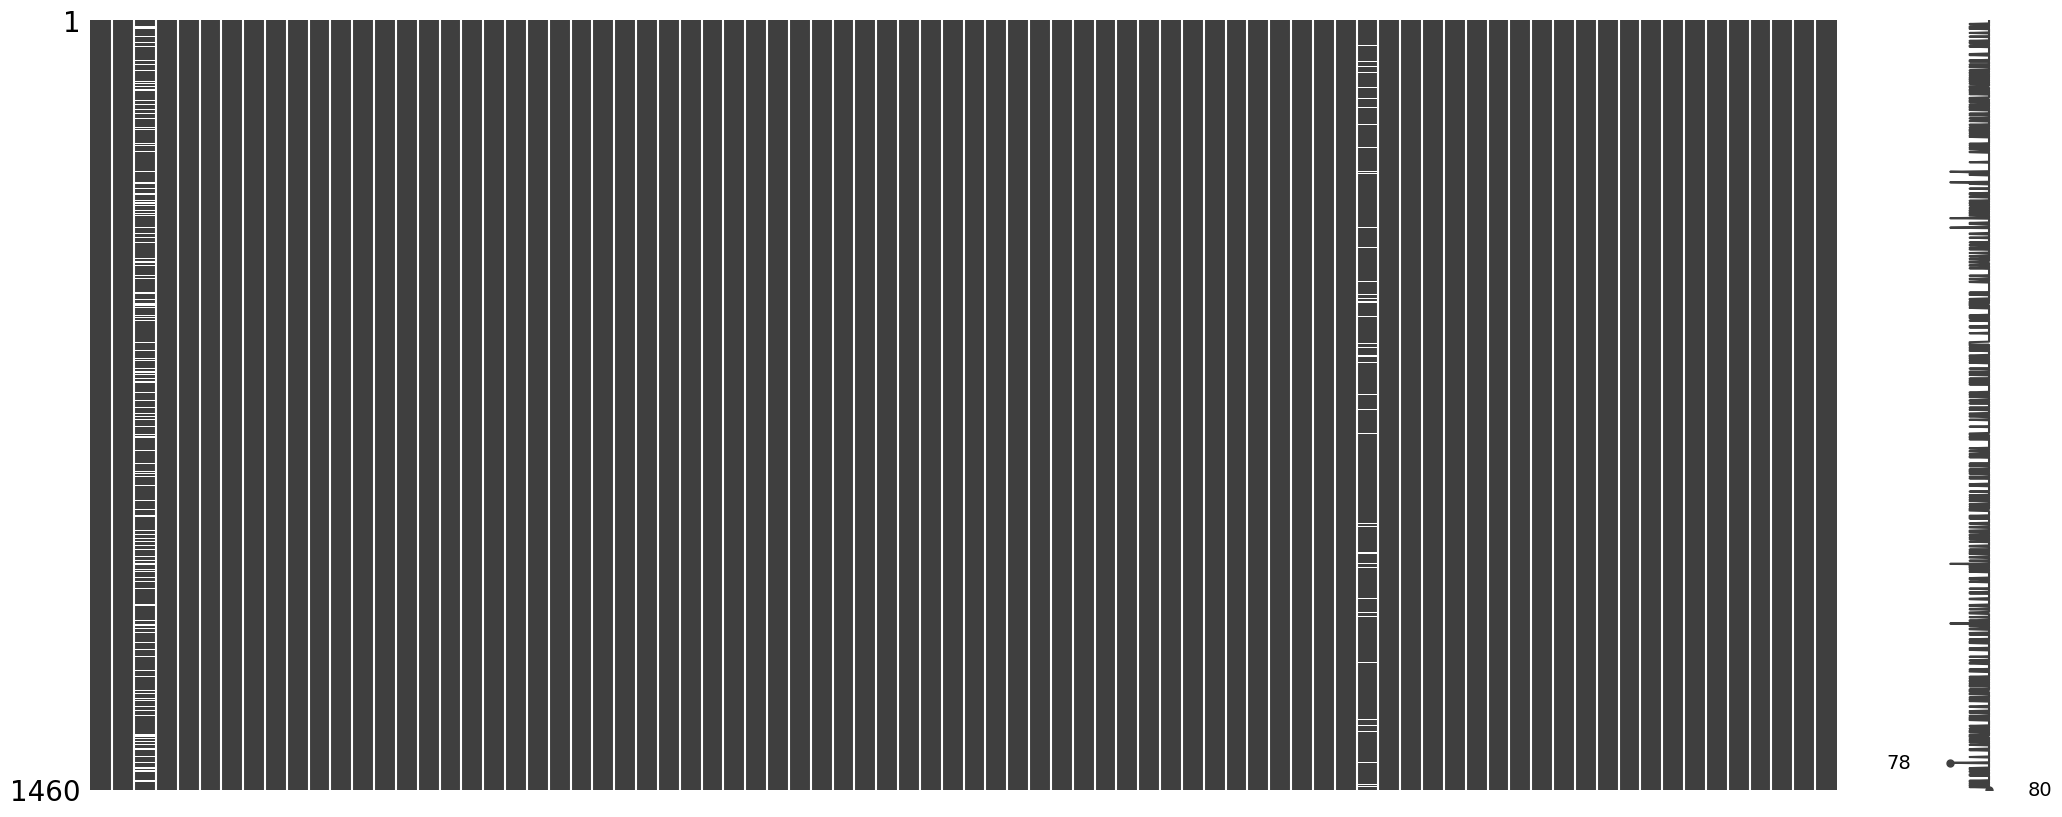

In [86]:
msno.matrix(train_clean)

<Axes: >

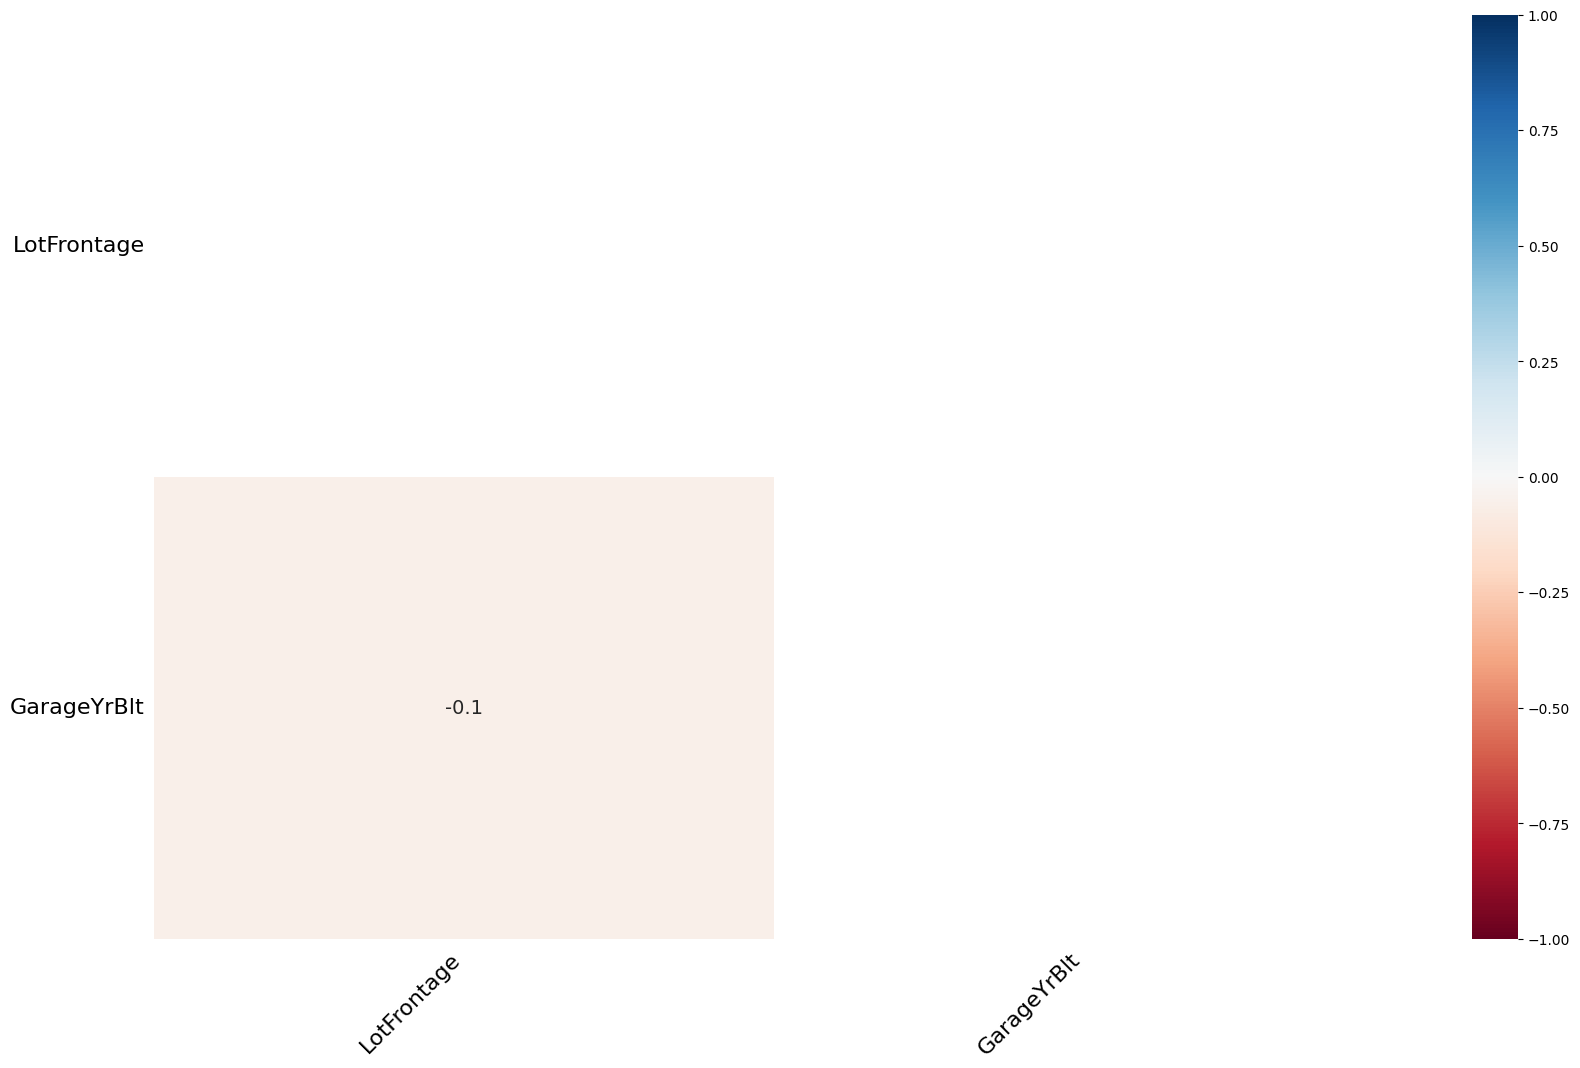

In [87]:
msno.heatmap(train_clean)

# Fill Missing Data

### YearBuilt

In [88]:
corr = train_clean[["GarageYrBlt", "YearBuilt"]].corr()
corr

,GarageYrBlt,YearBuilt
GarageYrBlt,1.000000,0.825667
YearBuilt,0.825667,1.000000


In [89]:
train_clean["GarageYrBlt"].fillna(train_clean["YearBuilt"],inplace=True)
test["GarageYrBlt"].fillna(test["YearBuilt"],inplace=True)

## LotFrontage

In [90]:
check_missing()

LotFrontage    259
dtype: int64

In [91]:
# sns.catplot(data=train_clean, x='LotFrontage',kind='strip', row='LotConfig', sharex=False,height=3,orient='portrait')

# plt.show()


In [92]:
lot_front_dic = train_clean.mask(train_clean.LotFrontage.isna()) \
            .groupby('LotConfig') \
                ['LotFrontage'].median().round() \
                .to_dict()

lot_front_dic

{'Corner': 80.0, 'CulDSac': 50.0, 'FR2': 64.0, 'FR3': 60.0, 'Inside': 68.0}

In [93]:
# missing_LF = train_clean[(train_clean.LotConfig == key) & (train_clean.LotFrontage.isna())]  

for key, item in lot_front_dic.items():
    train_clean.loc[((train_clean.LotConfig==key ) & (train_clean.LotFrontage.isna())), 'LotFrontage'] = item
    # test.loc[((train_clean.LotConfig==key ) & (train_clean.LotFrontage.isna())), 'LotFrontage'] = item

In [94]:
check_missing(train_clean)

Series([], dtype: int64)

In [95]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1460 non-null   category
 1   MSZoning       1460 non-null   category
 2   LotFrontage    1460 non-null   float64 
 3   LotArea        1460 non-null   int64   
 4   Street         1460 non-null   category
 5   Alley          1460 non-null   category
 6   LotShape       1460 non-null   category
 7   LandContour    1460 non-null   category
 8   Utilities      1460 non-null   category
 9   LotConfig      1460 non-null   category
 10  LandSlope      1460 non-null   category
 11  Neighborhood   1460 non-null   category
 12  Condition1     1460 non-null   category
 13  Condition2     1460 non-null   category
 14  BldgType       1460 non-null   category
 15  HouseStyle     1460 non-null   category
 16  OverallQual    1460 non-null   int64   
 17  OverallCond    1460 non-null   int64  

In [96]:
train_clean.to_csv('datasets/train_clean_clean.csv')
test.to_csv('datasets/test_clean.csv')

# Drop Columns

### Drop 8 rows of ManVnrArea

In [97]:
train_clean.dropna(axis = 'rows', subset=["MasVnrArea"], inplace=True)

### Drop categorical columns  with more than 600 missing values

In [98]:
# t = int(train_clean.shape[0]*.90)
# train_clean.dropna(axis='columns', thresh= t, inplace=True)

### Drop Columns Dominated by a certain value

In [99]:
# unbalanced_cols = []
# for col in train_clean.select_dtypes('object').columns:
#     value_counts = train_clean[col].value_counts(normalize=True)

#     max = value_counts.max()
    
#     print(value_counts)
#    # print(max)

#     if max > .70:
#         unbalanced_cols.append(col)


In [100]:
# train_clean.drop(unbalanced_cols, axis='columns',inplace=True)
# check_missing()

In [101]:
# train_clean.dropna(axis=0,inplace=True)
# print(train_clean.shape)
# check_missing()

# Feature Importance

## Correlation of Predictors with Target Variables

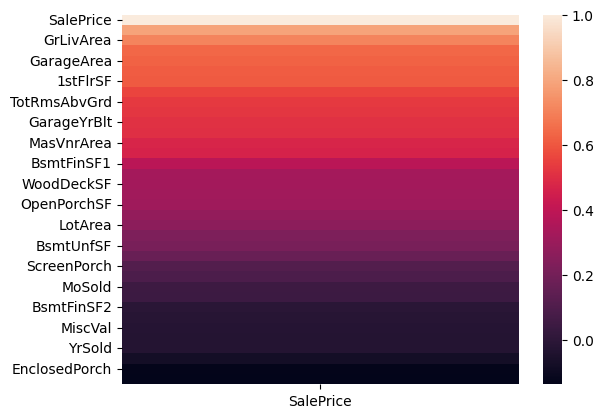

In [102]:
# def plot_correlation_heatmap(target_col: str or None):

#     corr_data: pd.DataFrame
    
#     if target_col is None:
corr_price = train_clean.corr(method='pearson', numeric_only=True)['SalePrice'].sort_values(ascending=False)
#     elif isinstance(target_col, str):
#         corr_data = train_clean.corr(method='pearson')

sns.heatmap(corr_price.to_frame())
plt.show()

# plot_correlation_heatmap('SalePrice')

## Correlation between Predictor Variables (Multicollinearity)

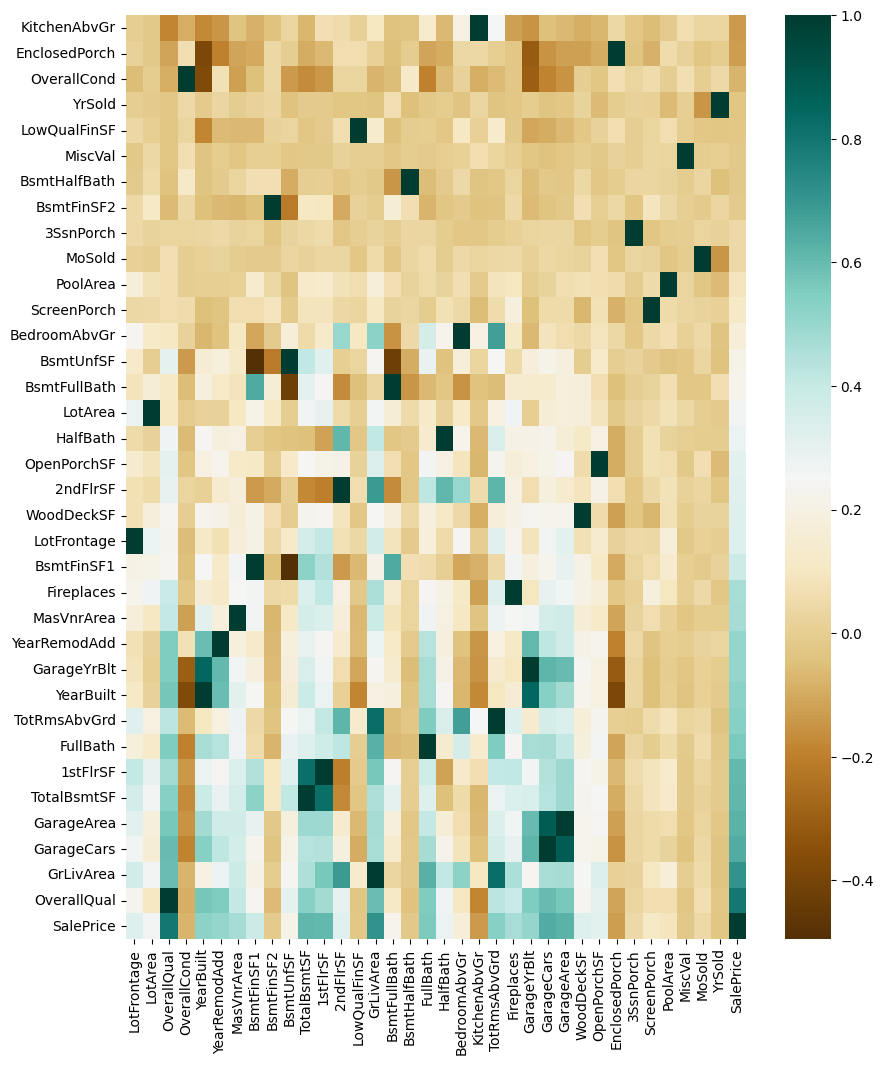

In [103]:
corr_df = train_clean.corr(method='pearson', numeric_only=True).sort_values(by='SalePrice')
fig = plt.figure(figsize=(10,12))
sns.heatmap(corr_df,cmap='BrBG', figure=fig )
plt.show()

In [104]:
corr_df


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
KitchenAbvGr,-0.003554,-0.017784,-0.183882,-0.087001,-0.174800,-0.149598,-0.038450,-0.081007,-0.040751,0.030086,...,-0.090130,-0.070091,0.037312,-0.024600,-0.051613,-0.014525,0.062341,0.026589,0.031687,-0.135907
EnclosedPorch,0.015774,-0.018340,-0.113937,0.070356,-0.387268,-0.193919,-0.109907,-0.102303,0.036543,-0.002538,...,-0.125989,-0.093079,1.000000,-0.037305,-0.082864,0.054203,0.018361,-0.028887,-0.009916,-0.128578
OverallCond,-0.055732,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,0.040229,-0.136841,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YrSold,-0.002879,-0.014261,-0.027347,0.043950,-0.013618,0.035743,-0.008317,0.014359,0.031706,-0.041258,...,0.022270,-0.057619,-0.009916,0.018645,0.010694,-0.059689,0.004906,-0.145721,1.000000,-0.028923
LowQualFinSF,0.038490,0.004779,-0.030429,0.025494,-0.183784,-0.062419,-0.068628,-0.064503,0.014807,0.028167,...,-0.025444,0.018251,0.061081,-0.004296,0.026799,0.062157,-0.003793,-0.022174,-0.028921,-0.025606
MiscVal,-0.018308,0.038068,-0.031406,0.068777,-0.034383,-0.010286,-0.029512,0.003571,0.004940,-0.023837,...,-0.009551,-0.018584,0.018361,0.000354,0.031946,0.029669,1.000000,-0.006495,0.004906,-0.021190
BsmtHalfBath,-0.016186,0.048046,-0.040150,0.117821,-0.038162,-0.012337,0.027403,0.067418,0.070948,-0.095804,...,0.040161,-0.025324,-0.008555,0.035114,0.032121,0.020025,-0.007367,0.032873,-0.046524,-0.016844
BsmtFinSF2,0.043069,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.071330,-0.050117,1.000000,-0.209294,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378
3SsnPorch,0.046340,0.020423,0.030371,0.025504,0.031355,0.045286,0.019144,0.026451,-0.029993,0.020764,...,-0.032771,-0.005842,-0.037305,1.000000,-0.031436,-0.007992,0.000354,0.029474,0.018645,0.044584
MoSold,0.011062,0.001205,0.070815,-0.003511,0.012398,0.021490,-0.006723,-0.015727,-0.015211,0.034888,...,0.021011,0.071255,-0.028887,0.029474,0.023217,-0.033737,-0.006495,1.000000,-0.145721,0.046432


## Drop highly correlated independent variables

In [105]:
to_drop = corr_df.query('OverallCond >-.80 and OverallCond >.80').index.tolist()
to_drop.append('OverallQual')
train_clean.drop(columns=to_drop, inplace=True)
train_clean

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,MnPrv,NA,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,GdPrv,Shed,2500,5,2010,WD,Normal,266500


# Modeling

## Imports

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score


In [107]:
c =test.select_dtypes(include='object').columns.to_list()
d = train_clean.select_dtypes(include='object').columns.to_list()

## Preprocessing Pipeline

## Encoding

In [108]:
data_description


description
category   variable                                                   
MSSubClass 20                          1-STORY 1946 & NEWER ALL STYLES
           30                                     1-STORY 1945 & OLDER
           40                        1-STORY W/FINISHED ATTIC ALL AGES
           45                        1-1/2 STORY - UNFINISHED ALL AGES
           50                            1-1/2 STORY FINISHED ALL AGES
...                                                                ...
see        Abnorml     Abnormal Sale -  trade, foreclosure, short sale
           AdjLand                             Adjoining Land Purchase
           Alloca           Allocation - two linked properties with...
           Family                          Sale between family members
           Partial   Home was not completed when last assessed (ass...

[314 rows x 1 columns]

In [109]:
train_clean.query('Alley == Street')[['Alley','Street']].shape[0]

TypeError: Categoricals can only be compared if 'categories' are the same.

## Baseline Model (Linear Regression)    

In [ ]:
linear_reg = LinearRegression()

linear_reg.fit(x_train_clean, y_train_clean)

In [ ]:
for col in test.columns:
    if col not in x_train_clean.columns:
        test.drop(axis='column', columns=col, inplace=True)
        


In [ ]:
X_test_final = scale_encode(test)
check_missing(X_test_final)

In [ ]:
X_test_final.dropna(inplace=True)
y_pred = linear_reg.predict(X_test_final)
pd.Series(y_pred).to_csv('submission.csv')

## Baseline Model (Decision Tree)

In [ ]:
dt = DecisionTreeRegressor(criterion='squared_error')

dt.fit(x_train_clean, y_train_clean)

In [ ]:
dt.feature_names_in_

In [ ]:
dt.predict(X_test_final)